#### 安装python2没有的包
+ python2 -m pip install sqlalchemy
+ python2 -m pip install pyodbc

In [1]:
from sqlalchemy import create_engine
import pyodbc
import pandas as pd
import arcpy
import time
import requests
import json

### 1.创建渔网

语法
>CreateFishnet_management (out_feature_class, origin_coord, y_axis_coord, cell_width, cell_height, number_rows, number_columns, {corner_coord}, {labels}, {template}, {geometry_type})

In [13]:
arcpy.env.outputCoordinateSystem = arcpy.SpatialReference("WGS 1984")
arcpy.env.overwriteOutput =  True
fc = r'D:\rui\code_analysis\file\GIS\class2203\basic_data.gdb\chengdu'
desc = arcpy.Describe(fc)
out_fc = fc + '_fishnet'
arcpy.CreateFishnet_management(out_feature_class = out_fc,
                               origin_coord = str(desc.extent.XMin) + " " + str(desc.extent.YMin),
                               y_axis_coord = str(desc.extent.XMin) + " " + str(desc.extent.YMin+3),
                               cell_width = "0.003",
                               cell_height = "0.003",
                               number_rows = "",
                               number_columns = "",
                              #corner_coord = str(desc.extent.XMax) + " " + str(desc.extent.YMax),
                               labels = "NO_LABELS",
                               template = fc,
                               geometry_type = "POLYGON")

<Result 'D:\\rui\\code_analysis\\file\\GIS\\class2203\\basic_data.gdb\\chengdu_fishnet'>

### 2.求的每个网格中心坐标

#### 2.1添加字段，用于后面字段连接

In [14]:
out_fc = fc + '_fishnet'
for i in ['check_id','lat','lng']:
    arcpy.AddField_management(out_fc,i,'TEXT') 

#### 2.2向新加字段添加值。创建一个dataframe对象，用于API检索

In [15]:
tbs = []
fields = ['OID','SHAPE@XY','check_id','lat','lng']
with arcpy.da.UpdateCursor(out_fc,fields) as cursor:
    for row in cursor:
        tb = []
        row[2] = row[0]
        row[3] = row[1][1]
        row[4] = row[1][0]
        tb.append(row[2])
        tb.append(str(row[3])+','+str(row[4]))
        tbs.append(tb)
        cursor.updateRow(row)

In [16]:
df = pd.DataFrame(tbs,columns=['check_id','coords'])
df.head(5)

,check_id,coords
0,1,"30.5582442974,103.910433099"
1,2,"30.5582442974,103.913433099"
2,3,"30.5582442974,103.916433099"
3,4,"30.5582442974,103.919433099"
4,5,"30.5582442974,103.922433099"


In [18]:
len(df)

8856

### 3.通过百度获得最短交通耗时

#### 3.1按50个坐标进行字符串组合

In [7]:
[df['coords'][50:52]]

[50    30.5582442974,104.060433099
 51    30.5582442974,104.063433099
 Name: coords, dtype: object]

In [6]:
def get_coords(data_f,data_col):
    lsts = []
    for i in range(len(data_f)/50):
        lst = list(data_f[data_col][i*50:(i+1)*50])
        lsts.append(lst)
    last_lst = list(data_f[data_col][-(len(data_f)%50):])
    lsts.append(last_lst)
    return lsts

In [7]:
coords_lst = get_coords(df,'coords')
coords_lst[-1]

['30.8012442969,104.216433099',
 '30.8012442969,104.219433099',
 '30.8012442969,104.222433099',
 '30.8012442969,104.225433099',
 '30.8012442969,104.228433099',
 '30.8012442969,104.231433099']

In [69]:
len(coords_lst)

178

#### 添加|分隔符

In [11]:
coords_lst_use = ['|'.join(i) for i in coords_lst]
coords_lst_use[-1]

'30.8012442969,104.216433099|30.8012442969,104.219433099|30.8012442969,104.222433099|30.8012442969,104.225433099|30.8012442969,104.228433099|30.8012442969,104.231433099'

#### 3.2小数据跑流程，解析百度API，返回json数据

In [9]:
def get_time(coord_org,coord_des50,api_key):
    api_addr = 'https://api.map.baidu.com/routematrix/v2/driving?origins={}&destinations={}&tactics=11&coord_type=wgs84&ak={}'\
    .format(coord_org,coord_des50,api_key)
    print(api_addr)
    req = requests.get(api_addr)
    content = req.text
    sjson = json.loads(content)
    return sjson

coord_org = '30.6636990000,104.0725260000'
coord_des50 = coords_lst_use[-1]
api_key = '7B7xW0ZIymEbzVWxvagFmg6j40ly0QtH'
dt = get_time(coord_org,coord_des50,api_key)

https://api.map.baidu.com/routematrix/v2/driving?origins=30.6636990000,104.0725260000&destinations=30.8012442969,104.216433099|30.8012442969,104.219433099|30.8012442969,104.222433099|30.8012442969,104.225433099|30.8012442969,104.228433099|30.8012442969,104.231433099&tactics=11&coord_type=wgs84&ak=7B7xW0ZIymEbzVWxvagFmg6j40ly0QtH


#### 获得各点耗时

In [96]:
[i["duration"]["value"] for i in dt["result"]]

2841

#### 3.3代码组合，进行全数据分析

In [ ]:
#坐标组合函数
def get_coords(data_f,data_col,nums):
    lsts = []
    for i in range(len(data_f) / nums):
        #注意list函数和直接加方括号的区别
        lst = list(data_f[data_col][i * nums:(i + 1) * nums])
        lsts.append(lst)
    last_lst = list(data_f[data_col][-(len(data_f) % nums):])
    lsts.append(last_lst)
    return lsts

#获得交通耗时，最终返回一个时间列表
#做异常判断，防止网络问题
def get_time(coord_org,coord_des,api_key):
    try:
        api_addr = 'https://api.map.baidu.com/routematrix/v2/driving?origins={}&destinations={}&tactics=11&coord_type=wgs84&ak={}'\
    .format(coord_org,coord_des,api_key)
        req = requests.get(api_addr)
        content = req.text
        sjson = json.loads(content)
        lst = [i["duration"]["value"] for i in sjson["result"]]
        return lst
    except:
        time.sleep(2)
        print('>  get_time error  <'.center(80,'='))
        get_time(coord_org,coord_des,api_key)
        
#进行坐标与时间的组合，使用zip函数，并把值转换为padas对象，存储到数据库中

def get_final_data(coord_org,coord_des,api_key,tb_name):
    try:
        get_dur_dt = get_time(coord_org,coord_des,api_key)
        time.sleep(1)
#         print(get_dur_dt)
        coords_dt = coord_des.split('|')
#         print(coords_dt)
        zip_dt = pd.DataFrame(zip(coords_dt,get_dur_dt))
        print(zip_dt.head(5))
        zip_dt.to_sql(tb_name,engine,if_exists = 'append')
    except:
        time.sleep(1)
        print('>  get_final_data error  <'.center(80,'='))
        get_final_data(coord_org,coord_des,api_key,tb_name)
        
if __name__ == "__main__":
    t1 = time.time()
    coords_lst = get_coords(df,'coords',50)
    coords_lst_use = ['|'.join(i) for i in coords_lst]
    coord_center = '30.6636990000,104.0725260000'
    api_key = '7B7xW0ZIymEbzVWxvagFmg6j40ly0QtH'
    #这个库要提前建好
    database_name = 'traffic'
    table_name = 'traffic'
    engine = create_engine('mssql+pyodbc://:@CLAIRE/{}?driver=SQL server'.format(database_name))
    for i,coords in enumerate(coords_lst_use[:]):
        print(i,'processing...')
        get_final_data(coord_center,coords,api_key,table_name)
    t2 = time.time()
    print('time:{} seconds'.format(t2 - t1).center(80,'='))

#### 4.数据连接

#### 4.1读取后筛选数据

In [19]:
engine = create_engine('mssql+pyodbc://:@CLAIRE/traffic?driver=SQL server')
with engine.connect() as conn,conn.begin():
    data = pd.read_sql_table('traffic',conn)

In [20]:
data.head(2)

,index,0,1
0,0,"30.5582442974,103.910433099",2410
1,1,"30.5582442974,103.913433099",2429


In [21]:
data.columns = ['id','coords','time']
data.head(2)

,id,coords,time
0,0,"30.5582442974,103.910433099",2410
1,1,"30.5582442974,103.913433099",2429


In [22]:
df.head(2)

,check_id,coords
0,1,"30.5582442974,103.910433099"
1,2,"30.5582442974,103.913433099"


In [24]:
dv1 = pd.merge(df,data,left_on='coords',right_on='coords')
dv1.head(2)

,check_id,coords,id,time
0,1,"30.5582442974,103.910433099",0,2410
1,1,"30.5582442974,103.910433099",0,2412


In [27]:
dv1['minutes'] = dv1['time'] / 60
dv1 = dv1[['check_id','coords','minutes']]
dv1.head(2)

,check_id,coords,minutes
0,1,"30.5582442974,103.910433099",40.166667
1,1,"30.5582442974,103.910433099",40.200000


In [28]:
dv1.to_csv(r'D:\rui\code_analysis\file\GIS\class2203\traffic_data.csv')

#### 5.空间链接与可视化，在ArcGIS中进行
5.1链接属性表，将csv文件链接到渔网要素类上<br>
5.2工具：用反距离权重法进行分析<br>
Toolboxes\System Toolboxes\Geostatistical Analyst Tools.tbx\Interpolation\IDW<br>
5.3可视化"几何间隔"分30类

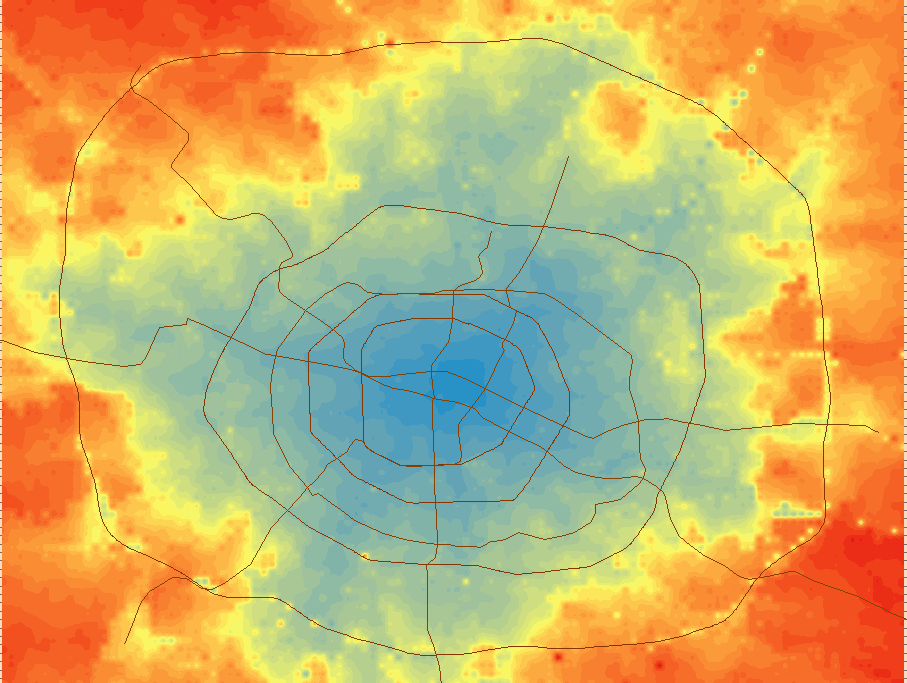